In [1]:
import numpy as np
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
sns.set_theme(style='whitegrid')

Franke function

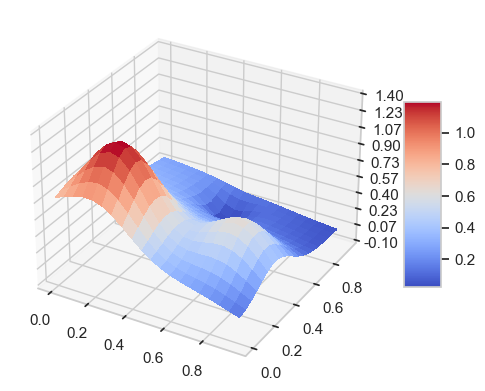

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Implementing the design matrix

In [6]:
def Vandermonde_design_matrix(x: np.ndarray, p: int) -> np.ndarray:
    """Sets up the design matrix given an input array x,
    and the degree of the polynomial fit"""
    Vandermonde = [x**i for i in range(p+1)]
    return np.hstack(Vandermonde)

First function for experimentation

In [7]:
np.random.seed(3)
n = 100
# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)

In [31]:
MSE_OLS_train = np.zeros(6)
MSE_OLS_test = np.zeros(6)
R2_OLS_train = np.zeros(6)
R2_OLS_test = np.zeros(6)

beta_values = []

for i in range(6):
    # Constructing the design matrix
    X = Vandermonde_design_matrix(x, i)

    # Splitting the data into train and test and scaling the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    ## scaling the data
    X_train_mean = np.mean(X_train, axis=0)

    x_train_scaled = X_train - X_train_mean
    x_test_scaled = X_test - X_train_mean

    y_mean = np.mean(y_train)
    y_train_scaled = y_train - y_mean


    # fitting the data with OLS
    OLS_beta = np.linalg.pinv(x_train_scaled.T @ x_train_scaled) @ x_train_scaled.T @ y_train_scaled

    intercept = np.mean(y_mean - X_train_mean @ OLS_beta)

    y_tilde_OLS = x_train_scaled @ OLS_beta + y_mean
    y_predict_OLS = x_test_scaled @ OLS_beta + y_mean

    MSE_OLS_train[i] = mean_squared_error(y_tilde_OLS, y_train)
    MSE_OLS_test[i] = mean_squared_error(y_predict_OLS, y_test)
    R2_OLS_train[i] = r2_score(y_tilde_OLS, y_train)
    R2_OLS_test[i] = r2_score(y_predict_OLS, y_test)

    beta_values.append(OLS_beta)

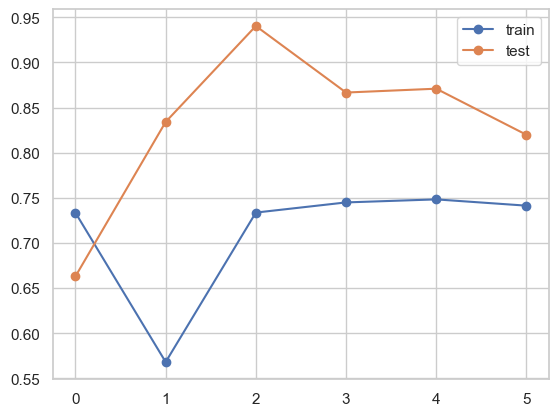

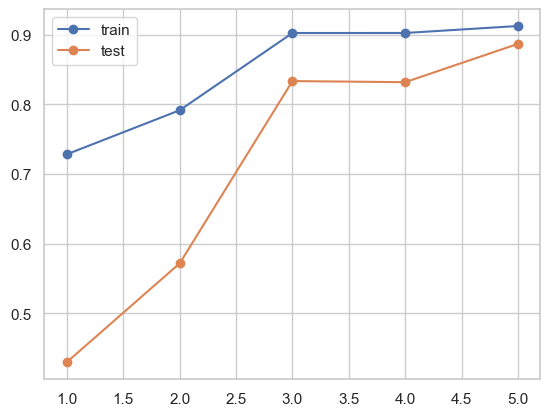

In [32]:
N = list(range(6))

plt.plot(N,MSE_OLS_train, 'o-', label='train')
plt.plot(N,MSE_OLS_test, 'o-', label='test')
plt.legend()
plt.show()

plt.plot(N[1:],R2_OLS_train[1:], 'o-', label='train')
plt.plot(N[1:],R2_OLS_test[1:], 'o-', label='test')
plt.legend()
plt.show()

In [26]:
print(beta_values)

[array([[0.]]), array([[0.        ],
       [0.27148507]]), array([[ 0.        ],
       [ 0.26509503],
       [-0.03945136]]), array([[ 0.        ],
       [ 0.46648054],
       [-0.04837141],
       [-0.03754793]]), array([[ 0.00000000e+00],
       [ 4.66129853e-01],
       [-5.06851398e-02],
       [-3.74614945e-02],
       [ 3.04539418e-04]]), array([[ 0.        ],
       [ 0.36992141],
       [-0.04648093],
       [ 0.01195624],
       [-0.00052898],
       [-0.00492239]])]


In [23]:
OLS_beta.shape

(6, 1)

In [22]:
beta_list[:][0]

array([[0.]])

In [15]:
for i in range(0, len(beta_list), -1):
    plt.scatter(list(range(i+1)), beta_list[i,:])
    #plt.scatter(list(range(i+1)), beta_list[i], label=f'{i}')

#plt.legend()
plt.show()